In [4]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

# Load and parse the data
df = pd.read_csv("simulated_sensor_data.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
df.set_index("timestamp", inplace=True)
df.head()


,temp_C,moisture_pct,co2_ppm,light_lux,fallback_active
timestamp,,,,,
2025-05-12 09:34:54.950835,22.76,60.2,398.0,0.0,False
2025-05-12 09:39:54.950835,23.23,60.3,408.0,0.0,False
2025-05-12 09:44:54.950835,23.57,60.3,402.0,0.0,False
2025-05-12 09:49:54.950835,23.73,60.6,393.0,0.0,False
2025-05-12 09:54:54.950835,23.44,59.7,400.0,0.0,False


In [5]:
# Set seed for reproducibility
np.random.seed(42)

# 2% dropout
dropout_pct = 0.02
dropout_indices = random.sample(list(df.index), int(len(df) * dropout_pct))

# Inject dropout
df.loc[dropout_indices, "moisture_pct"] = np.nan

# Preview dropout
print(f"Dropped out {len(dropout_indices)} moisture values.")
df["moisture_pct"].isna().sum()


Dropped out 17 moisture values.


np.int64(17)

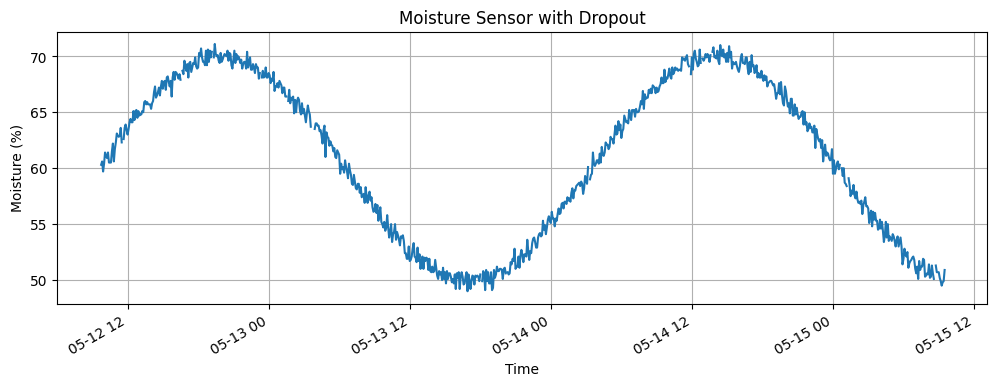

In [6]:
df["moisture_pct"].plot(figsize=(12, 4), title="Moisture Sensor with Dropout", grid=True)
plt.ylabel("Moisture (%)")
plt.xlabel("Time")
plt.show()


In [7]:
# Define start index for stuck-at fault (somewhere after hour 24)
stuck_start = 300
stuck_length = 100

# Apply stuck-at fault
df.iloc[stuck_start:stuck_start+stuck_length, df.columns.get_loc("temp_C")] = 37.0

print(f"Injected stuck-at-37.0°C fault from index {stuck_start} to {stuck_start + stuck_length}")


Injected stuck-at-37.0°C fault from index 300 to 400


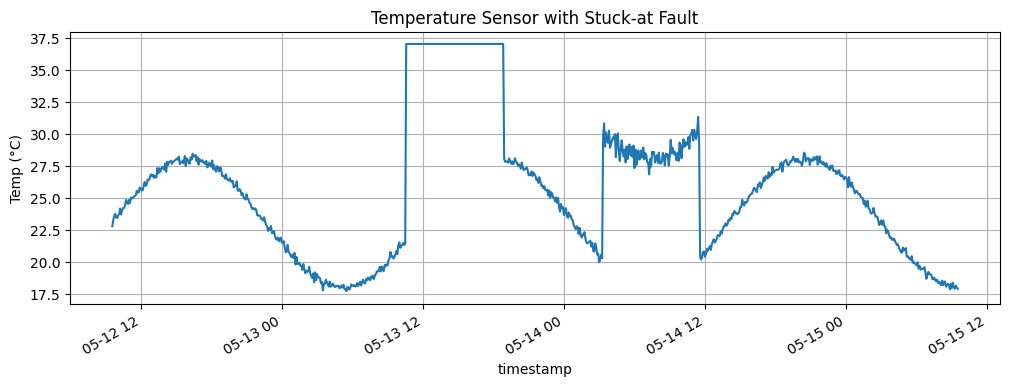

In [8]:
df["temp_C"].plot(figsize=(12, 4), title="Temperature Sensor with Stuck-at Fault", grid=True)
plt.ylabel("Temp (°C)")
plt.show()


In [9]:
# Choose start index for noise burst (e.g. hour 48)
noise_start = 576
noise_length = 30

# Inject noisy values
for i in range(noise_start, noise_start + noise_length):
    df.iloc[i, df.columns.get_loc("co2_ppm")] += np.random.normal(200, 50)  # Big deviation

print(f"Injected noise burst into CO₂ sensor from index {noise_start} to {noise_start + noise_length}")


Injected noise burst into CO₂ sensor from index 576 to 606


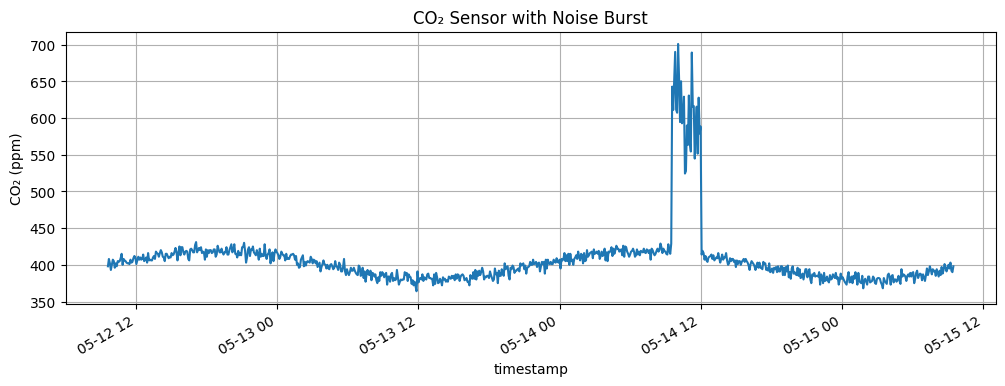

In [10]:
df["co2_ppm"].plot(figsize=(12, 4), title="CO₂ Sensor with Noise Burst", grid=True)
plt.ylabel("CO₂ (ppm)")
plt.show()


In [11]:
# Rule-based fallback reason generator
def get_fallback_reason(temp, moisture, co2, light):
    reasons = []

    # Rule 1: Overheat
    if temp > 35:
        reasons.append("high_temp")

    # Rule 2: Drought
    if moisture < 40:
        reasons.append("low_moisture")

    # Rule 3: Sensor dropout
    if pd.isna(moisture):
        reasons.append("moisture_dropout")

    # Rule 4: Suspicious CO₂ (e.g., > 800 ppm might be a fault)
    if co2 > 800:
        reasons.append("co2_noise")

    return reasons


In [2]:
# Loop through DataFrame and collect fallback logs
fallback_log = []

for idx, row in df.iterrows():
    reasons = get_fallback_reason(
        row["temp_C"], row["moisture_pct"], row["co2_ppm"], row["light_lux"]
    )
    
    if reasons:  # Only log if fallback condition(s) occurred
        fallback_log.append({
            "timestamp": str(idx),  # use str() to make it JSON serializable
            "reasons": reasons
        })

print(f"Total fallback events logged: {len(fallback_log)}")


NameError: name 'df' is not defined

In [3]:
# Preview first 3 fallback logs
fallback_log[:3]


[]